In [1]:
!apt install swig
!pip install orthnet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached orthnet-0.4.0.tar.gz (206 kB)
  Created wheel for orthnet: filename=orthnet-0.4.0-cp37-cp37m-linux_x86_64.whl size=157658 sha256=fe2d6102a55492e1e1f0d783020edf8a52c066894c158807a8320daf5c82b008
  Stored in directory: /root/.cache/pip/wheels/68/8c/c1/1344cc2d551c4f7c3831d216b39d50ccb07f4b3f3a5eb79c96
Successfully built orthnet


In [2]:

import torch
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
from torch import randn
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn

import random, os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

from orthnet import Legendre, Chebyshev

%matplotlib inline

GPU_MODE = True

In [3]:
if GPU_MODE:
  cuda0 = torch.device('cuda:0')
  print(torch.cuda.device_count(), torch.cuda.get_device_name(0))
  torch.cuda.init()

1 Tesla T4


In [4]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [5]:
class LegendreActivation(nn.Module):
    def __init__(self,degree):
        super().__init__()
        self.degree = degree
        self.data = None
        
        self.D = torch.zeros((degree , degree )) 
        for i in range(degree):
          for j in range(0 , i):
            if (i + j) % 2 == 1:
              self.D[i, j] = 2 * (j + 1) - 1
    
    def forward(self, X):              
      data = Legendre(X, self.degree).tensor
      self.data = data
      return data

    def backward(self,):
      return (self.D @ (self.data).T).T


class LegendreBlock(nn.Module):
    def __init__(self, n_input, degree):        
        super().__init__()
        self.degree = degree - 1
        self.n_input = n_input
        self.linear = nn.Linear(self.n_input, 1).double()
        self.tanh = nn.Tanh().double()
        self.Legendre = LegendreActivation(self.degree)

    def forward(self, X):      
      X = self.tanh(self.linear(X))      
      data = self.Legendre(X)
      return data

class ChebyshevActivation(nn.Module):
    def __init__(self,degree):
        super().__init__()
        self.degree = degree
        self.data = None
        
        self.D = torch.zeros((degree , degree )) 
        for i in range(degree):
          for j in range(0 ,i):
            if (i+j) % 2 == 1:
              self.D[i, j] = 2 * i
              if j == 0:
                self.D[i, j] = self.D[i, j]/2.0
    def forward(self, X):              
      data = Chebyshev(X, self.degree).tensor
      self.data = data
      return data

    def backward(self,):
      return (self.D @ (self.data).T).T

class ChebyshevBlock(nn.Module):
    def __init__(self, n_input, degree):        
        super().__init__()
        self.degree = degree - 1
        
        self.n_input = n_input
        self.linear = nn.Linear(self.n_input, 1).double()
        self.tanh = nn.Tanh().double()
        self.Chebyshev = ChebyshevActivation(self.degree)


    def forward(self, X):      
      X = self.tanh(self.linear(X))      
      data = self.Chebyshev(X)
      
      return data

In [6]:
def dy_dx(y, x):
  return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

def d2y_dx2(y, x):
  return dy_dx(dy_dx(y,x), x)

def d3y_dx3(y, x):
  return dy_dx(d2y_dx2(y,x), x)

In [7]:
domain = [0, 6]
n_discretization = 3000 * domain[1] - domain[0]

In [8]:
n_input = 1
n_output = 1
eps = 1e-10

In [9]:
if GPU_MODE:
  x = torch.linspace(domain[0] + eps, domain[1] - eps, n_discretization, dtype=torch.double, device=cuda0).reshape(-1,1)
  x = Variable(x, requires_grad=True).double()
else:
  x = torch.linspace(domain[0] + eps, domain[1] - eps, n_discretization, dtype=torch.double).reshape(-1,1)
  x = Variable(x, requires_grad=True).double()

In [10]:
mlp = nn.Sequential(  
  LegendreBlock(n_input, 32),
  nn.Linear(32, 64),
  nn.Tanh(),
  ChebyshevBlock(64, 128),
  nn.Linear(128, 64),
  nn.Tanh(),
  nn.Linear(64, 16),
  nn.Linear(16, n_output)
).double()


pytorch_total_params = sum(p.numel() for p in mlp.parameters() if p.requires_grad)
pytorch_total_params

11492

In [11]:
if GPU_MODE:
  mlp.to('cuda:0')

In [12]:
# print(mlp(x))

In [13]:
def get_loss(x, ret_res=False):
  y = mlp(x)
  y_x = dy_dx(y, x)
  y_xx = dy_dx(y_x, x)
  y_xxx = dy_dx(y_xx, x)


  """    
  Blasius Eq.: 
   f''' + 0.5 ff'' = 0
   2f''' + ff'' = 0   ,   f(0) = f'(0) = 0, f'(∞) = 1
  """
  
  residual = (2 * y_xxx) + (y_xx * y)


  # boundaries same for all equations
  boundary1 = y[0]
  boundary2 = y_x[0]
  boundary3 = y_x[-1] - 1

  loss = (residual**2).mean() + boundary1**2 + boundary2**2 + boundary3**2
  return (loss, residual) if ret_res else loss

In [14]:
def closure():
  loss = get_loss(x)
  optimizer.zero_grad()
  loss.backward()
  return loss

In [15]:
#TODO
optimizer = optim.Adam(list(mlp.parameters()), lr=0.015, betas=(0.9, 0.999), eps=1e-32)
previous = 0
losses = []
epoch_Adam = 100
epoch_LBFGS = 10000
for i in range(epoch_Adam):
  loss = get_loss(x)
  
  if i % 2 == 0:        
    print('Step: %03d loss = %016.10f' % (i, loss))        
  
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.detach().cpu().numpy())


optimizer = optim.LBFGS(list(mlp.parameters()), lr = 0.015035)
previous = 0
for i in range(epoch_LBFGS):
  loss = get_loss(x)
  if i % 2 == 0:        
    print('Step: %03d loss = %016.10f' % (i+epoch_Adam, loss))
    if abs(previous - loss) < 1e-10:
        print('converged')
        break
    
    previous = loss
  
  losses.append(loss.detach().cpu().numpy())
  optimizer.step(closure)

print("Final loss = %.2e" % get_loss(x))

Step: 000 loss = 8777163354.5154476166
Step: 002 loss = 211522051.9880294502
Step: 004 loss = 196436926.1528359354
Step: 006 loss = 884291882.7886766195
Step: 008 loss = 446623129.5760197639
Step: 010 loss = 168032431.2662857473
Step: 012 loss = 51927325.6794006377
Step: 014 loss = 39735403.1656018347
Step: 016 loss = 32829612.5805165842
Step: 018 loss = 25851331.1569498964
Step: 020 loss = 16436560.7818665020
Step: 022 loss = 8599137.2057308722
Step: 024 loss = 4668505.2273414051
Step: 026 loss = 3062055.4813562711
Step: 028 loss = 2265970.4697953723
Step: 030 loss = 1753338.9994863207
Step: 032 loss = 1360170.5927122065
Step: 034 loss = 1055624.9114564287
Step: 036 loss = 827676.8454664147
Step: 038 loss = 665352.0178041073
Step: 040 loss = 555677.3409419564
Step: 042 loss = 484354.6114313913
Step: 044 loss = 438066.7953114686
Step: 046 loss = 406098.4824990637
Step: 048 loss = 380880.7555247945
Step: 050 loss = 357802.1881831654
Step: 052 loss = 334637.5263268662
Step: 054 loss = 31

In [16]:
pd.options.display.float_format = '{:.16f}'.format
domain_test = torch.tensor([0.00,0.10,0.20,0.50,1.00,1.50,2.00], dtype=torch.double).reshape(-1,1)
predict_test = mlp.cpu().forward(domain_test).detach().numpy().flatten()
pd.DataFrame(np.array([domain_test.numpy().flatten(), predict_test]).T, columns=['x','y'])

,x,y
0,0.0000000000000000,0.0000875884382208
1,0.1000000000000000,0.0017539176345641
2,0.2000000000000000,0.0067480123501369
3,0.5000000000000000,0.0416819994989300
4,1.0000000000000000,0.1660340851922861
5,1.5000000000000000,0.3710283222676397
6,2.0000000000000000,0.6514661706244316


In [17]:
# calculate f''(0)
# # make zero Tensor from x Tensor
zerox = x.cpu().clone()
zerox[0][0] = 0
f_xx_0 = d2y_dx2(mlp(zerox), zerox)[0]
print("f''(0) = {}".format(f_xx_0[0]))

# history 
# f''(0) = 0.3325398571314273 
# f''(0) = 0.3321312229973239
# f''(0) = 1.021112600546433
# f''(0) = 0.404517927402095
# f''(0) = 0.3527060458059874
# f''(0) = 0.3361245899387143
# f''(0) = 0.3325213525146607

# lr = 0.009
# f''(0) = 0.33251437981586146
# f''(0) = 0.33254796361322553
# f''(0) = 0.3325401498497548


#  lr = 0.008
# f''(0) = 0.33254400651054716


# f''(0) = 0.33252665330415215
# f''(0) = 0.33261575689285827
# f''(0) = 0.3325313538155854
# f''(0) = 0.3325307197221751
# f''(0) = 0.33246800552478467
# f''(0) = 0.33254154443417766
# f''(0) = 0.33255285813823426
# f''(0) = 0.3325264476063145

# leg & cheb
# f''(0) = 0.33207066628053
# f''(0) = 0.3325757252417146
# f''(0) = 0.3325196659906537
# f''(0) = 0.3326295137397836 lr = 0.0099
# f''(0) = 0.3325228575080689 0.013
# f''(0) = 0.33252765971244347 0.018
# f''(0) = 0.32727825893531454 64>16 0.018
# f''(0) = 0.3326629901553025 0.008
# f''(0) = 0.3323973920681927 0.015
# f''(0) = 0.3325517198519129 0.01405
# f''(0) = 0.3318886899464448 0.01505
# f''(0) = 0.33245450440479507 0.015049

# f''(0) = 0.3324736631836589
# best
# f''(0) = 0.33206902302292145 lr=0.015035



f''(0) = 0.33206902302292145


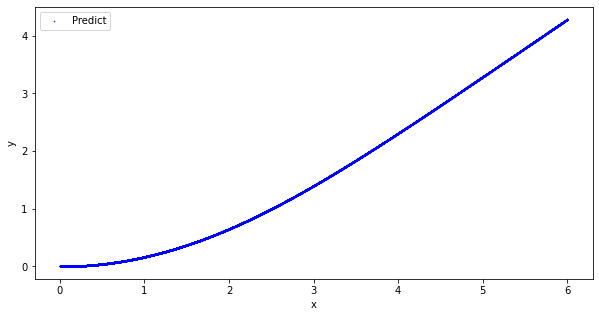

In [23]:
#[TODO]
domain = x.cpu().detach().numpy().flatten()
# exact = (1 - x**2 / 6).detach().numpy().flatten()
predict = mlp.forward(x.cpu()).detach().numpy().flatten()

plt.figure(figsize=(10, 5))
plt.xlabel('x')
plt.ylabel('y')

# plt.plot(domain, exact,'k--', markersize=.1, label='Exact')
plt.plot(domain, predict,'b.', markersize=1, label='Predict')
plt.legend()

# plt.savefig('exact-predict.eps', bbox_inches='tight', format='eps')

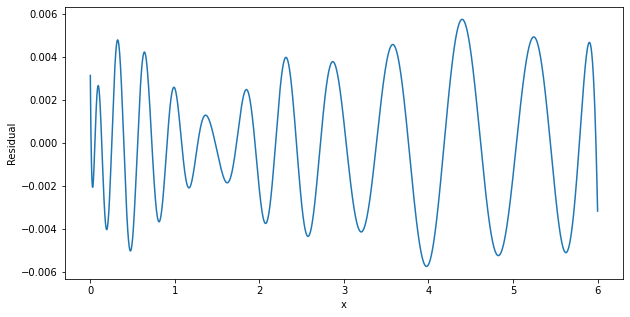

In [25]:
plt.figure(figsize=(10, 5))

res= get_loss(x.cpu(), ret_res=True)[1].detach().numpy()
plt.xlabel('x')
plt.ylabel('Residual')
plt.plot(domain, res)
plt.savefig('residual-loss.eps', bbox_inches='tight', format='eps')

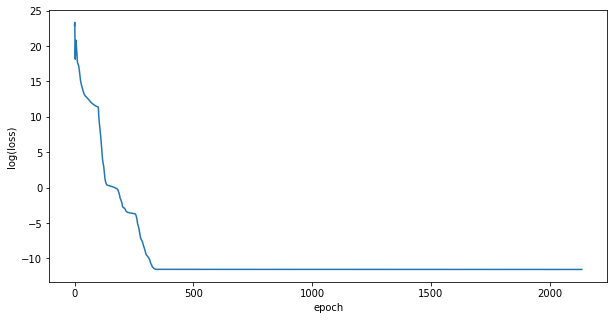

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(np.log(losses))
plt.xlabel('epoch')
plt.ylabel('log(loss)')

plt.savefig('loss.eps', bbox_inches='tight', format='eps')